In [39]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [40]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import MetaData
from sqlalchemy import create_engine, func

In [42]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:////Users/kellenquinn/Desktop/SQLALCHEMY/hawaii.sqlite")
conn = engine.connect()

In [43]:
Base=automap_base()
Base.prepare(engine, reflect=True)

In [44]:
# reflect an existing database into a new model
from sqlalchemy import MetaData

#Get MetaData in Sqlite
m=MetaData()
m.reflect(engine)
# reflect the tables
for table in m.tables.values():
    print(table.name)

    for column in table.c:
        print(column.name, column.type)

measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [45]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [46]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [47]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [48]:
# Find the most recent date in the data set.
from sqlalchemy import desc
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'The most recent observation was on {[most_recent for most_recent in most_recent]}.')

The most recent observation was on ['2017-08-23'].


Text(0, 0.5, 'Precipitation')

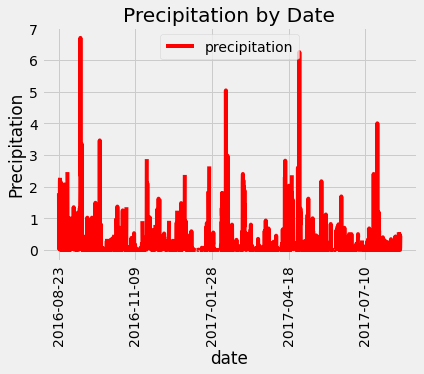

In [49]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
session.query(Measurement.prcp).order_by(Measurement.prcp.desc()).first()
# Calculate the date one year from the last date in data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_dt=dt.date.fromisoformat(last_date[0])
# last_date_dt=dt.datetime.strptime(last_date[0], 'YYYY-MM-DD')
prev_date_dt=last_date_dt-dt.timedelta(days=365)
prev_date_dt
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_date_dt).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(results, columns=["date", "precipitation"])
#rain_df = rain_df.set_index('date') <- causing KeyError
rain_df.head()

# Sort the dataframe by date
rain_sorted_df = rain_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
rain_sorted_df.plot(kind='line', x='date', y='precipitation', color='red')
plt.title("Precipitation by Date")
plt.xlabel("date")
plt.xticks(rotation=90)
plt.ylabel("Precipitation")


In [50]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_sorted_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [51]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement.station).distinct().count()


9

In [52]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()   
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [53]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = 'USC00519281'
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == station_id).all()

[(54.0, 85.0, 71.66378066378067)]

In [54]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == station_id).\
    filter(Measurement.date > prev_date_dt)
most_active_temp_df = pd.DataFrame(temp)   
most_active_temp_df.head() 

,0,1,2
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


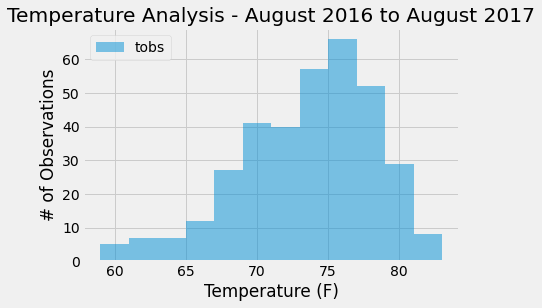

In [55]:
#Histogram plot of tobs data from most active station
most_active_temp_df.plot.hist(bins=12, alpha=0.5)
plt.title("Temperature Analysis - August 2016 to August 2017")
plt.xlabel("Temperature (F)")
plt.ylabel("# of Observations")
plt.legend(['tobs'], loc='upper left')


# Close session

In [56]:
# Close Session
session.close()